        1    2     3     4     5  ...     26     27     28     29     30
Date                              ...                                   
0     4.0  0.0   0.0   3.0   4.0  ...   38.0   39.0   40.0   39.0   42.0
0     4.0  1.0   0.0   3.0   3.0  ...   13.0   14.0   13.0   11.0   13.0
0     5.0  0.0   0.0   4.0   4.0  ...    6.0    8.0    5.0    1.0    5.0
0     0.0  1.0  15.0  47.0  83.0  ...  318.0  320.0  321.0  320.0  322.0
0     5.0  0.0   0.0   4.0   4.0  ...    7.0    7.0    6.0    3.0    6.0
...   ...  ...   ...   ...   ...  ...    ...    ...    ...    ...    ...
419   0.0  0.0   0.0   0.0   0.0  ...    2.8    2.8    2.8    2.8    2.7
419   0.0  0.0   0.0   0.0   0.0  ...    2.7    2.7    2.6    2.6    2.7
419   0.0  0.0   0.0   0.0   0.0  ...    6.6    7.4    8.2    8.9    9.5
419   0.0  0.0   0.0   0.0   0.0  ...    2.2    2.2    2.1    1.9    1.9
419   0.0  0.0   0.0   0.0   0.0  ...    1.9    2.1    2.0    2.0    2.0

[2520 rows x 30 columns]
(420, 1)
(420, 30, 6)
Mod

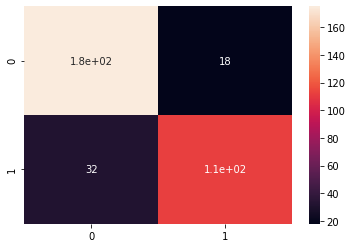

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
#Reading the H5 file
filename = "sensors_data_augmented.h5"
h5f = h5py.File(filename,'r')
sensors_data = h5f['dataset_1'][:]
h5f.close()
#The H5 file contains also the information of a temperature sensor, that you can discard
sensors_data_final = sensors_data[:,[1,2,3,4,5,6],:]#Not using temperature 
with open('binary_labels_augmented.txt') as f:
    lines = f.readlines()
X = sensors_data_final
y = lines
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
df = pd.DataFrame([list(l) for l in X]).stack().apply(pd.Series).reset_index(1, drop=True)
df.index.name = 'Date'
df.columns = [str(i) for i in range(1,301)]
df_30 = df[[str(i) for i in range(1,31)]]
print(df_30)
x = []
for i in range(len(X)):
    x.append(df_30.loc[i].to_numpy())
X = x
X = np.array(X)
X.shape
y = np.array(y)
y = np.reshape(y,(420, 1))
print(y.shape)
y_train = y[:337,:]
y_test = y[:337,:]
X = np.reshape(X,(420, 30, 6))
print(X.shape)
X_train = X[:337,:]
X_test = X[:337,:]
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=3,kernel_regularizer=l2(0.005), input_shape=(n_timesteps,n_features)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(filters=30, kernel_size=2,kernel_regularizer=l2(0.005)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='sigmoid'))
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0004,decay=0.0000001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
hist = model.fit(X_train,
                 y_train,
                 batch_size = 50,
                 epochs=500,
                 validation_data=(X_test, y_test),
                 shuffle = True,
                 callbacks = [ModelCheckpoint("model.hdf5",
                              monitor = 'val_accuracy',
                              save_best_only = True,
                              save_weights_only = False,
                              save_freq= 'epoch')])
from keras.models import load_model
model.load_weights('model.hdf5')
model.evaluate(X_test, y_test)
from sklearn.metrics import confusion_matrix,classification_report
y_pred=[]
model.load_weights('model.hdf5')
Y_pred = model.predict(X_test)
for elt in Y_pred:
  if elt < 0.5 : 
    y_pred.append(0)
  else:
    y_pred.append(1)
#print(Y_pred)
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
print(sns.heatmap(cm, annot=True))
print('Classification Report')
class_labels = y_test 
report = classification_report(y_test, y_pred)
print(report) 

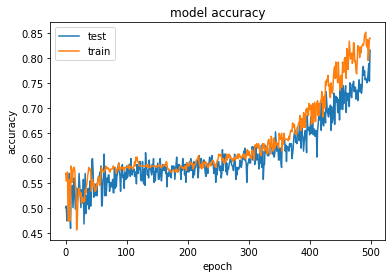

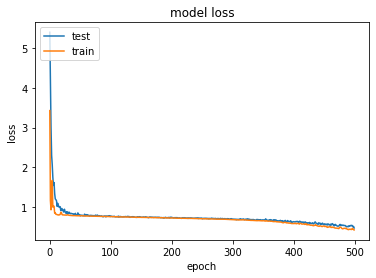

In [2]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()